In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
"""
The MIT License (MIT)

Copyright (c) 2021 NVIDIA

Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
"""

import torch
from torch.utils.data import DataLoader

def train_model(model, device, epochs, batch_size, trainset, testset,
                optimizer, loss_function, metric):
    # Transfer model to GPU.
    model.to(device)

    # Create dataloaders.
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    acc = False
    mae = False
    if(metric == 'acc'):
        acc = True
    elif(metric == 'mae'):
        mae = True
    else:
        print('Error: unsupported metric')
        return

    for i in range(epochs):
        model.train() # Set model in training mode.
        train_loss = 0.0
        if(acc):
            train_correct = 0
        if(mae):
            train_absolute_error = 0.0
        train_batches = 0
        for inputs, targets in trainloader:
            # Move data to GPU.
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the parameter gradients.
            optimizer.zero_grad()

            # Forward pass.
            outputs = model(inputs)
            loss = loss_function(outputs, targets)

            # Accumulate metrics.
            if(acc):
                _, indices = torch.max(outputs.data, 1)
                train_correct += (indices == targets).sum().item()
            if(mae):
                train_absolute_error += (targets - outputs.data).abs().sum().item()
            train_batches +=  1
            train_loss += loss.item()

            # Backward pass and update.
            loss.backward()
            optimizer.step()

        train_loss = train_loss / train_batches
        if(acc):
            train_acc = train_correct / (train_batches * batch_size)
        if(mae):
            train_mae = train_absolute_error / (train_batches * batch_size)

        # Evaluate the model on the test dataset.
        model.eval() # Set model in inference mode.
        test_loss = 0.0
        if(acc):
            test_correct = 0
        if(mae):
            test_absolute_error = 0.0
        test_batches = 0
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            if(acc):
                _, indices = torch.max(outputs.data, 1)
                test_correct += (indices == targets).sum().item()
            if(mae):
                test_absolute_error += (targets - outputs.data).abs().sum().item()
            test_batches +=  1
            test_loss += loss.item()
        test_loss = test_loss / test_batches
        if(acc):
            test_acc = test_correct / (test_batches * batch_size)
            print(f'Epoch {i+1}/{epochs} loss: {train_loss:.4f} - acc: {train_acc:0.4f} - val_loss: {test_loss:.4f} - val_acc: {test_acc:0.4f}')
            return_value = [train_acc, test_acc]
        if(mae):
            test_mae = test_absolute_error / (test_batches * batch_size)
            print(f'Epoch {i+1}/{epochs} loss: {train_loss:.4f} - mae: {train_mae:0.4f} - val_loss: {test_loss:.4f} - val_mae: {test_mae:0.4f}')
            return_value = [train_mae, test_mae]
    return return_value

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import csv

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 100
BATCH_SIZE = 16

TRAIN_TEST_SPLIT = 0.8
MIN = 12
FILE_NAME = '/content/drive/MyDrive/data/book_store_sales.csv'

def readfile(file_name):
    data = []
    with open(file_name, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        next(reader)  # Skip header row
        for row in reader:
            # Remove commas from the string before converting to float
            value = row[1].replace(',', '')
            data.append(float(value))
    return np.array(data, dtype=np.float32)

# Read data and split up into train and test data.
sales = readfile(FILE_NAME)
months = len(sales)
split = int(months * TRAIN_TEST_SPLIT)
train_sales = sales[0:split]
test_sales = sales[split:]

# To verify, print the first few elements of train_sales and test_sales
print(train_sales[:5])
print(test_sales[:5])


[790. 539. 535. 523. 552.]
[ 659. 1106. 1207.  634.  652.]


In [10]:
data_books = readfile('/content/drive/MyDrive/data/book_store_sales.csv')
data_hobby = readfile('/content/drive/MyDrive/data/hobby_toy_games.csv')
data_sports = readfile('/content/drive/MyDrive/data/sporting good stores.csv')

In [11]:
data = np.stack((data_books, data_hobby, data_sports), axis=1)

In [12]:
data

array([[ 790.,  620.,  972.],
       [ 539.,  585., 1100.],
       [ 535.,  643., 1214.],
       ...,
       [ 559., 1519., 4126.],
       [ 596., 1669., 4991.],
       [ 596., 1471., 4573.]], dtype=float32)

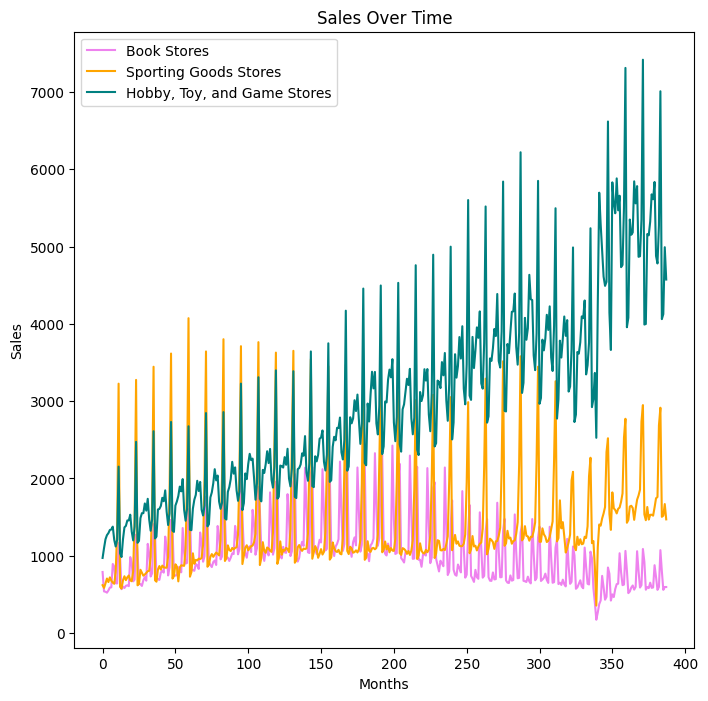

In [23]:
x = range(len(data))

plt.figure(figsize=(8, 8))

# Use different colors
plt.plot(x, data[:, 0], color='violet', linestyle='-', label='Book Stores')
plt.plot(x, data[:, 1], color='orange', linestyle='-', label='Sporting Goods Stores')
plt.plot(x, data[:, 2], color='teal', linestyle='-', label='Hobby, Toy, and Game Stores')

plt.title('Sales Over Time')
plt.xlabel('Months')
plt.ylabel('Sales')
plt.legend()
plt.show()

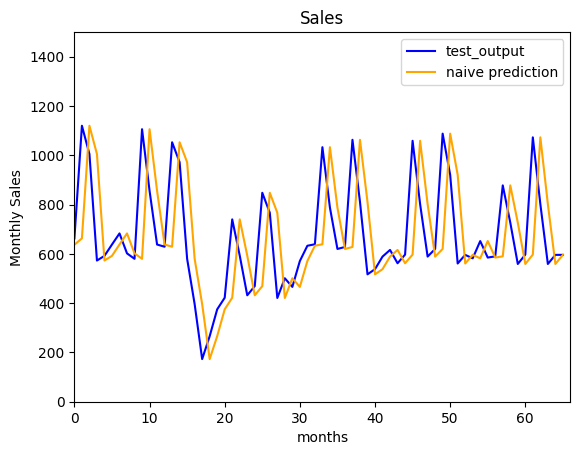

In [29]:
# Plot naive prediction
test_output = test_sales[MIN:]
naive_prediction = test_sales[MIN-1:-1]
x = range(len(test_output))
plt.plot(x, test_output, 'blue', label='test_output')
plt.plot(x, naive_prediction, 'orange', label='naive prediction')
plt.title('Sales')
plt.axis([0, len(test_output), 0.0, 1500.0])
plt.xlabel('months')
plt.ylabel('Monthly Sales')
plt.legend()
plt.show()


In [30]:
# Standardize train and test data.
# Use only training seasons to compute mean and stddev.
mean = np.mean(train_sales)
stddev = np.std(train_sales)
train_data_std = (train_sales - mean)/stddev
test_data_std = (test_sales - mean)/stddev


In [31]:
# Create train examples.
train_months = len(train_sales)
train_X = np.zeros((train_months-MIN, train_months-1, 1), dtype=np.float32)
train_y = np.zeros((train_months-MIN, 1), dtype=np.float32)
for i in range(0, train_months-MIN):
    train_X[i, -(i+MIN):, 0] = train_data_std[0:i+MIN]
    train_y[i, 0] = train_data_std[i+MIN]

# Create test examples.
test_months = len(test_sales)
test_X = np.zeros((test_months-MIN, test_months-1, 1), dtype=np.float32)
test_y = np.zeros((test_months-MIN, 1), dtype=np.float32)
for i in range(0, test_months-MIN):
    test_X[i, -(i+MIN):, 0] = test_data_std[0:i+MIN]
    test_y[i, 0] = test_data_std[i+MIN]

# Create Dataset objects.
trainset = TensorDataset(torch.from_numpy(train_X).clone(), torch.from_numpy(train_y))
testset = TensorDataset(torch.from_numpy(test_X).clone(), torch.from_numpy(test_y))


In [32]:
# Custom layer that retrieves only last time step from RNN output.
class LastTimestep(nn.Module):
    def forward(self, inputs):
        return inputs[1][0]

# Create RNN model
model = nn.Sequential(
    nn.RNN(1, 128, nonlinearity='relu', num_layers=2, batch_first=True),
    LastTimestep(),
    nn.Linear(128, 1)
)

# Loss function and optimizer.
optimizer = torch.optim.Adam(model.parameters())
loss_function = nn.MSELoss()

# Train model.
train_model(model, device, EPOCHS, BATCH_SIZE, trainset, testset,
            optimizer, loss_function, 'mae')


Epoch 1/100 loss: 0.9692 - mae: 0.7409 - val_loss: 1.1642 - val_mae: 0.7977
Epoch 2/100 loss: 0.8499 - mae: 0.6774 - val_loss: 1.1376 - val_mae: 0.7926
Epoch 3/100 loss: 0.6453 - mae: 0.6180 - val_loss: 0.8386 - val_mae: 0.6643
Epoch 4/100 loss: 0.5347 - mae: 0.5554 - val_loss: 0.3102 - val_mae: 0.3600
Epoch 5/100 loss: 0.4841 - mae: 0.5163 - val_loss: 0.1850 - val_mae: 0.3048
Epoch 6/100 loss: 0.4232 - mae: 0.4751 - val_loss: 0.2226 - val_mae: 0.2908
Epoch 7/100 loss: 0.4878 - mae: 0.5201 - val_loss: 0.4646 - val_mae: 0.4457
Epoch 8/100 loss: 0.3881 - mae: 0.4634 - val_loss: 0.2236 - val_mae: 0.2701
Epoch 9/100 loss: 0.3821 - mae: 0.4639 - val_loss: 0.3851 - val_mae: 0.3251
Epoch 10/100 loss: 0.4928 - mae: 0.5472 - val_loss: 0.5337 - val_mae: 0.5485
Epoch 11/100 loss: 0.5195 - mae: 0.5611 - val_loss: 0.4297 - val_mae: 0.4904
Epoch 12/100 loss: 0.4145 - mae: 0.5013 - val_loss: 0.2521 - val_mae: 0.3633
Epoch 13/100 loss: 0.3644 - mae: 0.4621 - val_loss: 0.2234 - val_mae: 0.3179
Epoch 14

[0.09973981937295512, 0.1517563559114933]

In [33]:
# Create naive prediction based on standardized data.
test_output = test_data_std[MIN:]
naive_prediction = test_data_std[MIN-1:-1]
mean_squared_error = np.mean(np.square(naive_prediction
                                       - test_output))
mean_abs_error = np.mean(np.abs(naive_prediction
                                - test_output))
print('naive test mse: ', mean_squared_error)
print('naive test mean abs: ', mean_abs_error)


naive test mse:  0.28295425
naive test mean abs:  0.3978397


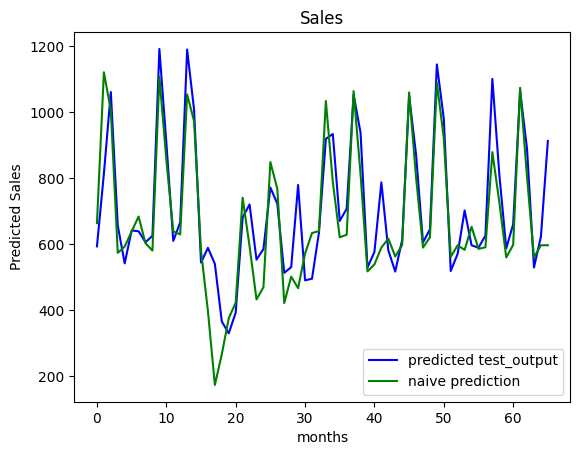

In [40]:
# Use trained model to predict the test data
inputs = torch.from_numpy(test_X)
inputs = inputs.to(device)
outputs = model(inputs)
predicted_test = outputs.cpu().detach().numpy()

# De-standardize output.
predicted_test = np.reshape(predicted_test,
                            (len(predicted_test)))
predicted_test = predicted_test * stddev + mean

# Plot test prediction.
x = range(len(test_sales)-MIN)
plt.plot(x, predicted_test, 'b-',
         label='predicted test_output')
plt.plot(x, test_sales[-(len(test_sales)-MIN):],
         'g-', label='naive prediction')
# plt.plot(x, naive_prediction, 'm-', label='naive prediction')
plt.title('Sales')
# plt.axis([0, 55, 0.0, 3000.0])
plt.xlabel('months')
plt.ylabel('Predicted Sales')
plt.legend()
plt.show()


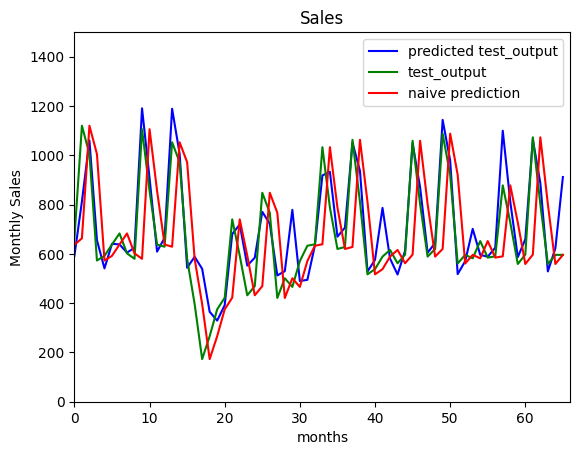

In [43]:
# Plot naive prediction
test_output = test_sales[MIN:]
naive_prediction = test_sales[MIN-1:-1]
x = range(len(test_output))
plt.plot(x, predicted_test, 'b-',
         label='predicted test_output')
plt.plot(x, test_output, 'g-', label='test_output')
plt.plot(x, naive_prediction, 'r-', label='naive prediction')
plt.title('Sales')
plt.axis([0, len(test_output), 0.0, 1500.0])
plt.xlabel('months')
plt.ylabel('Monthly Sales')
plt.legend()
plt.show()

In [44]:
naive_prediction = test_sales[MIN-1:-1]

In [45]:
naive_prediction

array([ 637.,  663., 1120., 1005.,  573.,  592.,  638.,  683.,  602.,
        580., 1106.,  856.,  638.,  629., 1053.,  972.,  580.,  396.,
        173.,  266.,  375.,  422.,  740.,  593.,  432.,  469.,  848.,
        767.,  421.,  501.,  466.,  571.,  633.,  639., 1033.,  788.,
        620.,  628., 1063.,  811.,  517.,  538.,  589.,  616.,  562.,
        597., 1059.,  802.,  589.,  620., 1088.,  921.,  561.,  596.,
        582.,  652.,  585.,  590.,  878.,  727.,  559.,  597., 1073.,
        802.,  559.,  596.], dtype=float32)